In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from pathlib import Path
from skimage.exposure import rescale_intensity, histogram
from skimage.filters import threshold_otsu
from skimage.io import imread
from skimage.measure import label, regionprops
from skimage.morphology import area_opening, opening, disk, reconstruction
from iaf.morph.watershed import separate_neighboring_objects
from iaf.color import get_labels_cmap
from iaf.plot import imshow, show_labels
from iaf.notebook import init_style
init_style()

# Analysis pipeline

This example shows how to enhance an image as a preprocessing step before analysis. In this example, we correct the nonuniform background illumination and convert the image into a binary image so that we can perform analysis of the image foreground objects.

## Read and display the image

In [5]:
I = imread(Path(Path.home() / "openbis/raw_data/20240916113758953-89/original/notebooks_data/rice.png"))

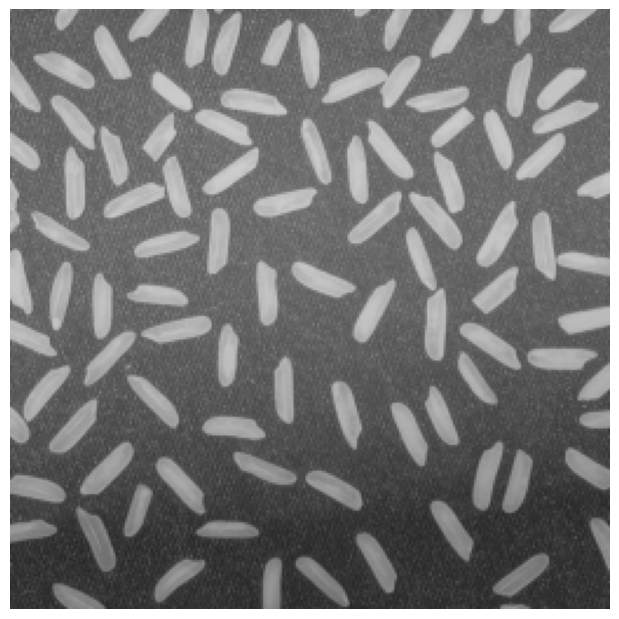

In [6]:
imshow(I)

## Preprocess the Image to Enable Analysis

In the sample image, the background illumination is brighter in the center of the image than at the bottom. As a preprocessing step before analysis, make the background uniform and then convert the image into a binary image. To make the background illumination more uniform, create an approximation of the background as a separate image and then subtract this approximation from the original image.
As a first step to creating a background approximation image, remove all the foreground (rice grains) using morphological opening. The opening operation has the effect of removing objects that cannot completely contain the structuring element. To remove the rice grains from the image, the structuring element must be sized so that it cannot fit entirely inside a single grain of rice. The example calls the strel function to create a disk-shaped structuring element with a radius of 15.

In [7]:
# Structuring element
selem = disk(15)

In [8]:
# Run morphological opening
background = opening(I, selem) # Very slow for large images!

Plot the extracted background.

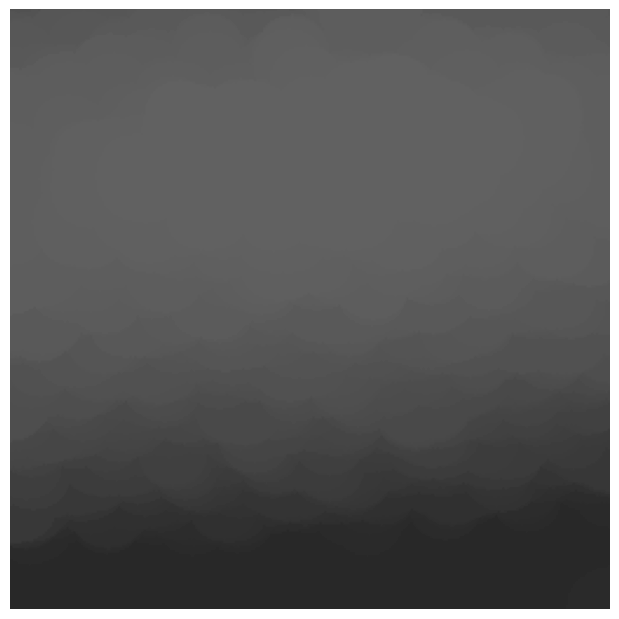

In [9]:
imshow(background)

Subtract the background from the original image and plot the result.

In [10]:
I2 = I - background

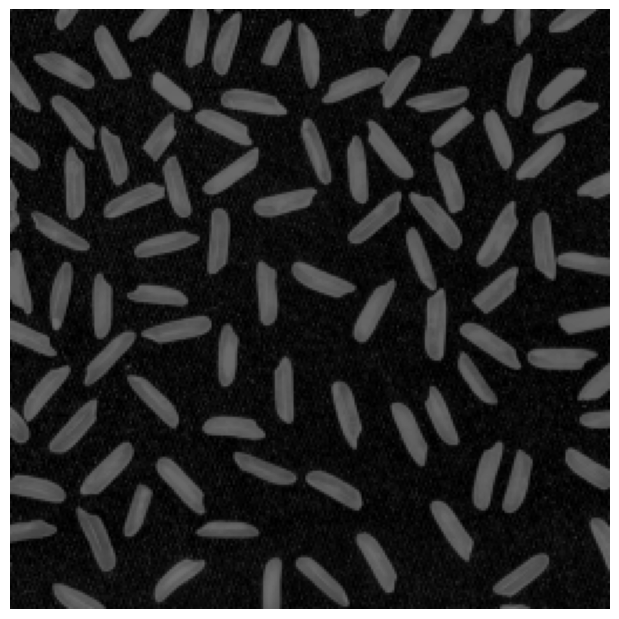

In [11]:
imshow(I2)

**Note**: for large images, morphological opening can be quite computationally intensive: [iaf.process.subtract_background](https://ia-res.ethz.ch/docs/iaf/process/index.html#iaf.process.subtract_background) implements a series of algorithms and optimizations to speed up the background subtraction.

The image is a bit dark. Let's stretch the intensities by dropping 1% of the intensities at both ends of the dynamic range.

In [12]:
p_low, p_high = np.percentile(I2, (1, 99))
I3 = rescale_intensity(I2, in_range=(p_low, p_high))

Let's display the image.

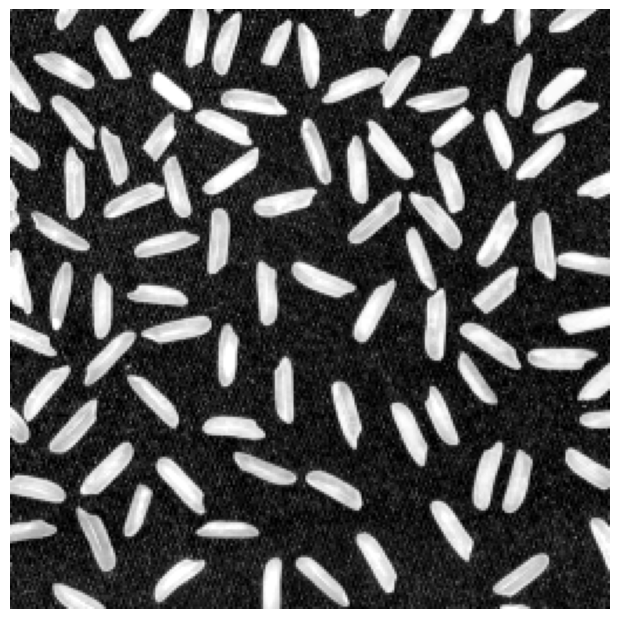

In [13]:
imshow(I3)

## Segment the image

We use the **Otsu** algorithm to find a threshold to segment the grains from the background-corrected image.

In [14]:
threshold = threshold_otsu(I3)
print(f"Threshold = {threshold}")

Threshold = 122


In [15]:
bw = I3 > threshold

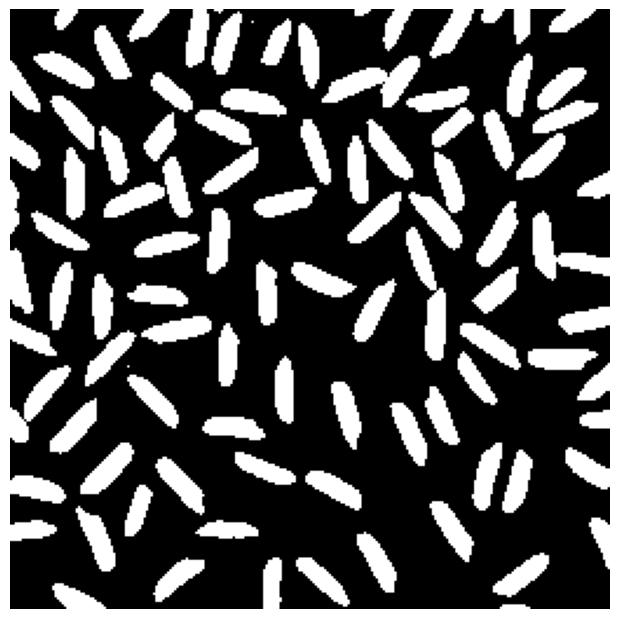

In [16]:
imshow(bw)

We use **area opening** (a morphological operation with a non-fixed structuring elements of given area) to remove small objects.

In [17]:
bw = area_opening(bw, area_threshold=50)

**Note**: for a quicker alternative to `area_opening`, consider [iaf.morph.watershed.filter_labels_by_area](https://ia-res.ethz.ch/docs/iaf/morph/watershed/index.html#iaf.morph.watershed.filter_labels_by_area).

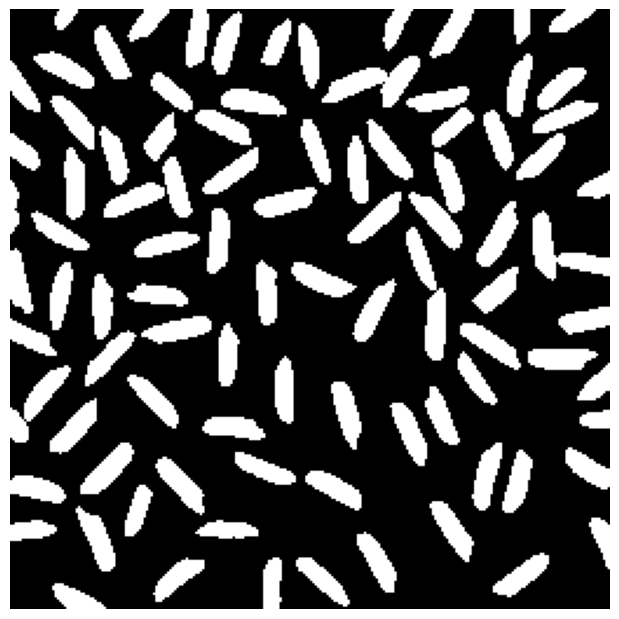

In [18]:
imshow(bw)

## Perform analysis of the objects in the image

Now that we have created a binary version of the original image, we can perform analysis of objects in the image. We will find all the **connected components** (objects) in the binary image. The accuracy of our results will depend on the size of the objects, the connectivity parameter (4, 8, or arbitrary), and whether or not any objects are touching (in which case they could be labeled as one object).

In [19]:
labels, num = label(bw, background=0, return_num=True, connectivity=1)
print(f"Found {num} connected components.")

Found 95 connected components.


Let's plot the extracted labels in color.

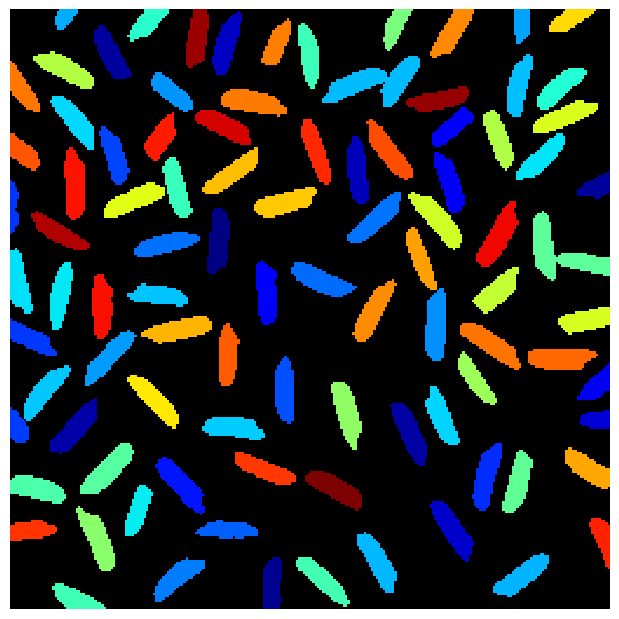

In [20]:
show_labels(labels)

Let's look at one of the rice grains, say number 65.

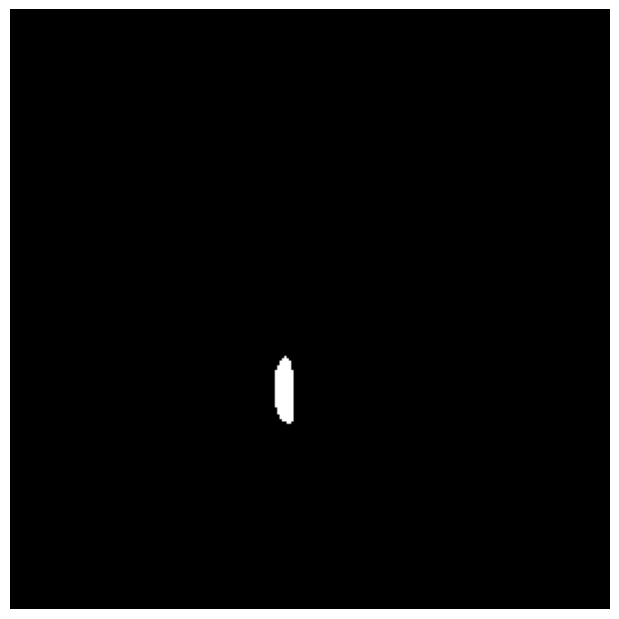

In [21]:
bw_65 = np.where(labels == 65, True, False)
imshow(bw_65)

We can now measure various properties for each of the labels in the image.

In [22]:
props = regionprops(labels)

Let's extracts all areas.

In [23]:
areas = []
for prop in props:
    areas.append(prop.area)

Let's look at some characteristics of our areas.

In [24]:
areas = np.array(areas)

In [25]:
print(f"Median area = {np.median(areas)}; max area = {areas.max()}")

Median area = 190.0; max area = 404.0


The largest rice grain has twice the area of the median rice grain. This suggests that some of the rice grains were not properly segmented and resulted in the same connected component. Let's see how the largest grain looks like:

In [26]:
# We add 1 to the index since `areas` does not contain the background.
index = np.argmax(areas) + 1
print(f"The largest object has area {areas[index - 1]} and index {index}.")

The largest object has area 404.0 and index 14.


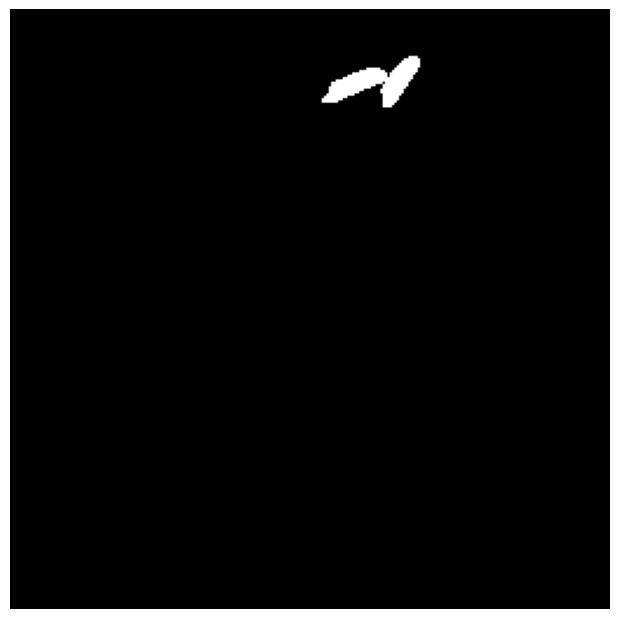

In [27]:
bw_largest = np.where(labels == index, True, False)
imshow(bw_largest)

## Perform watershed segmentation

Watershed segmentation is very prone to over segmentation. To avoid that, we need to use labels to prevent this from happening.

Calculate the watershed image.

In [28]:
labels_ws, num_ws, _ = separate_neighboring_objects(bw, labels)
print(f"Found {num_ws} connected components.")

Found 97 connected components.


From the 95 objects we had before watershed segmentation, we now have 97.

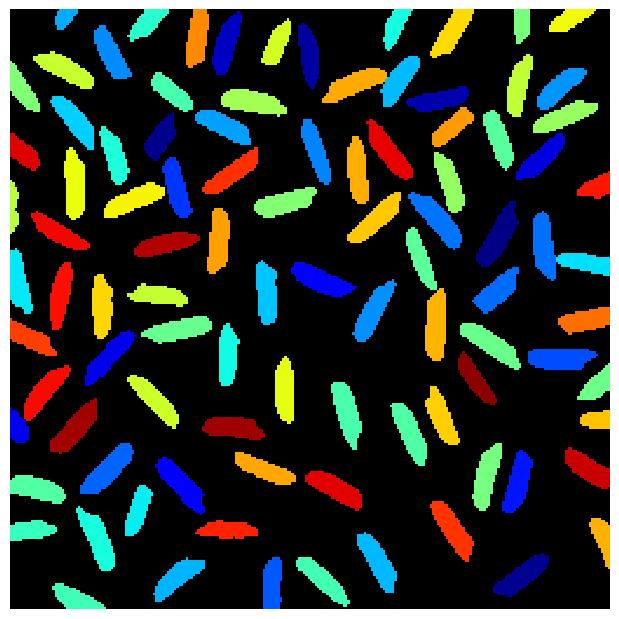

In [29]:
show_labels(labels_ws)

Let's measure the properties of the new objects for comparison.

In [30]:
props_ws = regionprops(labels_ws)

We compare the areas with those from previous segmentation.

In [31]:
areas_ws = []
for prop in props_ws:
    areas_ws.append(prop.area)
areas_ws = np.array(areas_ws)    

In [32]:
print(f"Median area = {np.median(areas_ws)}; max area = {areas_ws.max()}")

Median area = 190.0; max area = 236.0


Looks better now.